In [2]:
####!/apps/anaconda3/bin/python

from random import choices 
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect_right
import os
from scipy import optimize
import datetime
from joblib import Parallel, delayed
import joblib
import csv   
from time import gmtime, strftime
from sklearn.neighbors import KernelDensity
from itertools import product
import ast
from scipy import integrate
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T
import scipy.stats as stats
import math
from collections import deque
from os.path import isfile, join
from os import listdir
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import pylab as py
import seaborn as sns  
import statistics
# In[45]:
from scipy.integrate import quad

from Stability_queue_functions import *

# Generate no distribution shift data, will be useful later

In [ ]:
evaluate_policy_under_distribution(arrival_distribution, service_distribution, mixture_prob_arrival, mixture_prob_service,'no distribution shift',number_of_simulations = 100000)
# it will save the file into file of the form './Result/model_data/no_distribution_shift_newv_10K_data__2023-08-15_20:49:09.pkl'

# Figure 13, computing worst case expectation

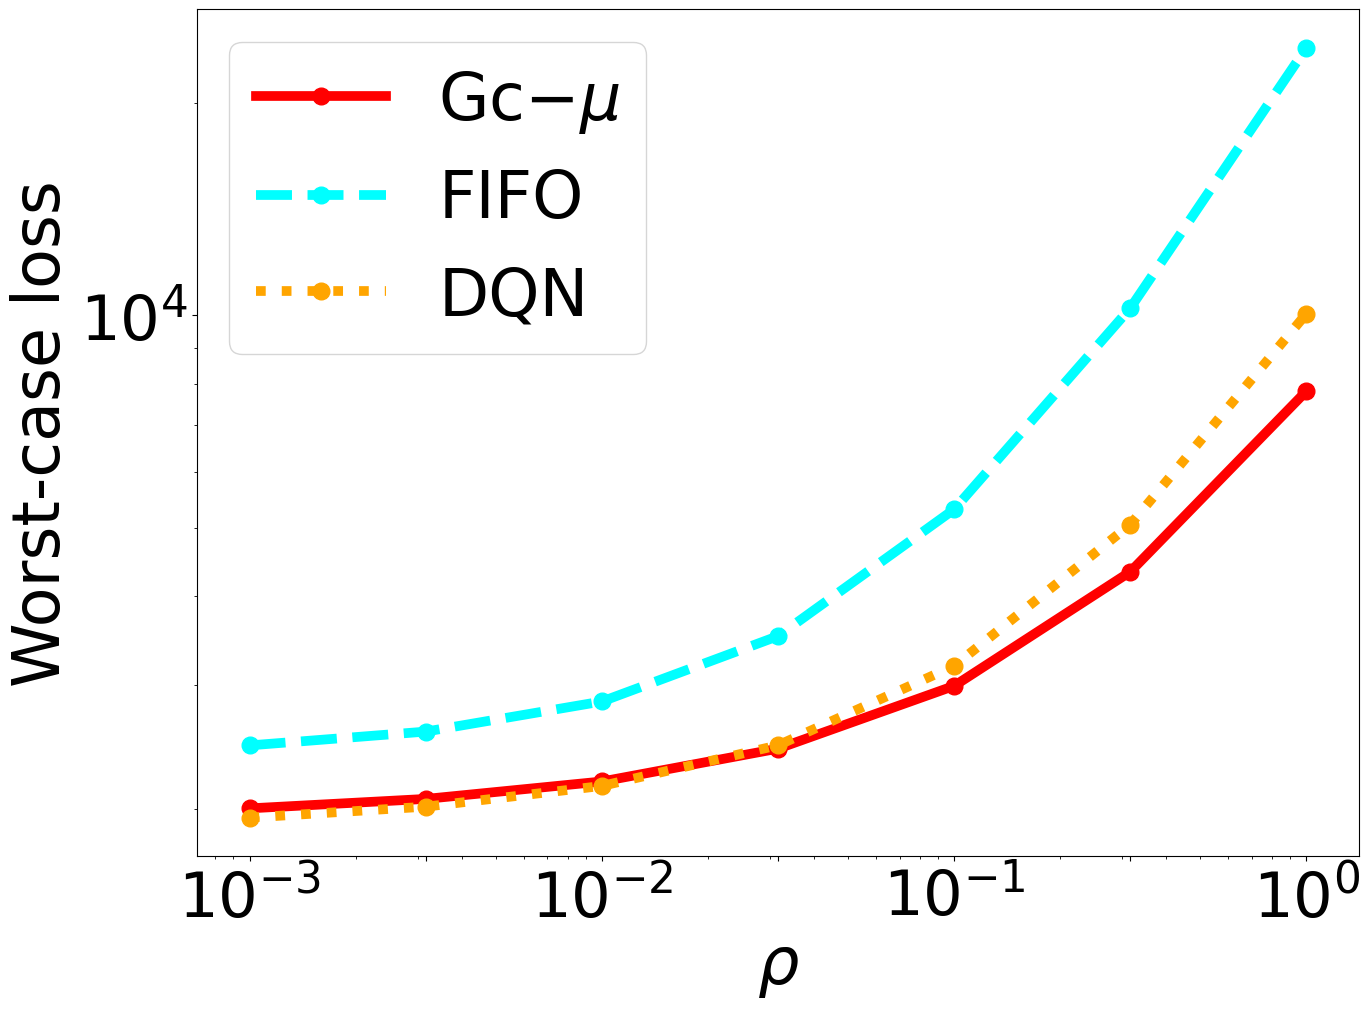

In [15]:
data_0 = joblib.load('./Result/model_data/no distribution shift_data__2023-08-13_15:09:18.pkl')
    
def worst_case_estimator_grad(alpha,rho,x):
    '''
    x is the input random observations, alpha is the parameter we want to find, rho is the thresohld
    '''
    exp_alpha_x = np.exp([1/alpha*_ for _ in x]) 
    temp_1 = np.log(np.mean(exp_alpha_x)) + rho 
    temp_2 =  np.mean(np.multiply(x,exp_alpha_x)) / np.mean(exp_alpha_x) 
    grad = temp_1 - 1/alpha * temp_2 
    return (grad)


def worst_case_expectation(x,rho): #return the stability measure, input is the data we want to compute and the threshold
    alpha_star = optimize.bisect(worst_case_estimator_grad,1000, 100000,args=(rho,x), maxiter=100000000,xtol=0.0000001)
    exp_alpha_x = np.exp([1/alpha_star*_ for _ in x]) 
    worst_case_measure =  alpha_star* ( np.log(np.mean(exp_alpha_x)) + rho)
        
    return {'worst_case_measure':round(worst_case_measure,5),'mean':round(np.mean(x),2),'std':round(np.std(x),2),'alpha_star':round(alpha_star,14)}


threshold_list = [10**(x) for x in [-3,-2.5,-2,-1.5,-1,-0.5,0]]

worst_case_expectation_result = {}
for d in ['c_mu_result','FIFO_result','DRL_result']:
    worst_case_expectation_result[d] = []


for threshold in threshold_list:
    for d in ['c_mu_result','FIFO_result','DRL_result']:
        #print(threshold, d)
        worst_case_expectation_result[d].append(worst_case_expectation(data_0[d],threshold)['worst_case_measure'])

    
line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

sub_sample = [0,1,2,3,4,5]

def f(x,s):
    return x
    #return np.array(x)[s]

marker_size = 24

fig, ax = plt.subplots(1, 1)


ax.plot(f(threshold_list,sub_sample), f(worst_case_expectation_result['c_mu_result'],sub_sample),'r',label='Gc$-\mu$', linestyle='-',linewidth = line_width, marker=".", markersize = marker_size) 
ax.plot(f(threshold_list,sub_sample), f(worst_case_expectation_result['FIFO_result'],sub_sample),'cyan',label='FIFO', linestyle='--',linewidth = line_width, marker=".", markersize = marker_size)  
ax.plot(f(threshold_list,sub_sample), f(worst_case_expectation_result['DRL_result'],sub_sample),'orange',label='DQN', linestyle='dotted',linewidth = line_width, marker=".", markersize = marker_size) 

    
# plt.plot(threshold_list, stability_measure_result['c_mu_result'],'r',label='Gc$-\mu$', linestyle='-.',linewidth = line_width) 
# plt.plot(threshold_list, stability_measure_result['FIFO_result'],'cyan',label='FIFO', linestyle='--',linewidth = line_width) 
# plt.plot(threshold_list, stability_measure_result['DRL_result'],'orange',label='DQN', linestyle='dotted',linewidth = line_width) 
    
    
    
ax.set_xlabel(r'$\rho$', fontsize=fig_size)
ax.set_ylabel('Worst-case loss', fontsize=fig_size)
ax.legend(prop={'size': fig_size}) 
ax.set_xscale('log')
ax.set_yscale('log',base = 10)
ax.set_xticks(threshold_list)
#ax.set_xticks([10**3, 10**4, 10**5])

ax.tick_params(axis='x', labelsize=fig_size-2)
ax.tick_params(axis='y', labelsize=fig_size-2)
plt.savefig('/user/ym2865/Result/model_data/worst_case_expectation_plot_queue.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show() 

# Generate the "true value" of the stability measure, which is estimated using 500,000 samples

In [4]:
evaluate_policy_under_distribution(arrival_distribution, service_distribution, mixture_prob_arrival, mixture_prob_service,'no distribution shift_500',number_of_simulations = 500000)
data_0 = joblib.load('./Result/model_data/no distribution shift_500_data__2023-08-31_20:48:17.pkl')


for d in ['c_mu_result','FIFO_result','DRL_result']:
    print(d,stability_measure(data_0[d], thres))

c_mu_result {'stability_measure': 0.15888, 'mean': 1931.63, 'std': 1638.82, 'lambda_star': 0.00011138916016}
FIFO_result {'stability_measure': 0.0547, 'mean': 2345.56, 'std': 2274.78, 'lambda_star': 4.986572266e-05}
DRL_result {'stability_measure': 0.12978, 'mean': 1855.37, 'std': 1743.02, 'lambda_star': 8.575439453e-05}


# Figure 5, mean squared error of stability estimators for queueing policies

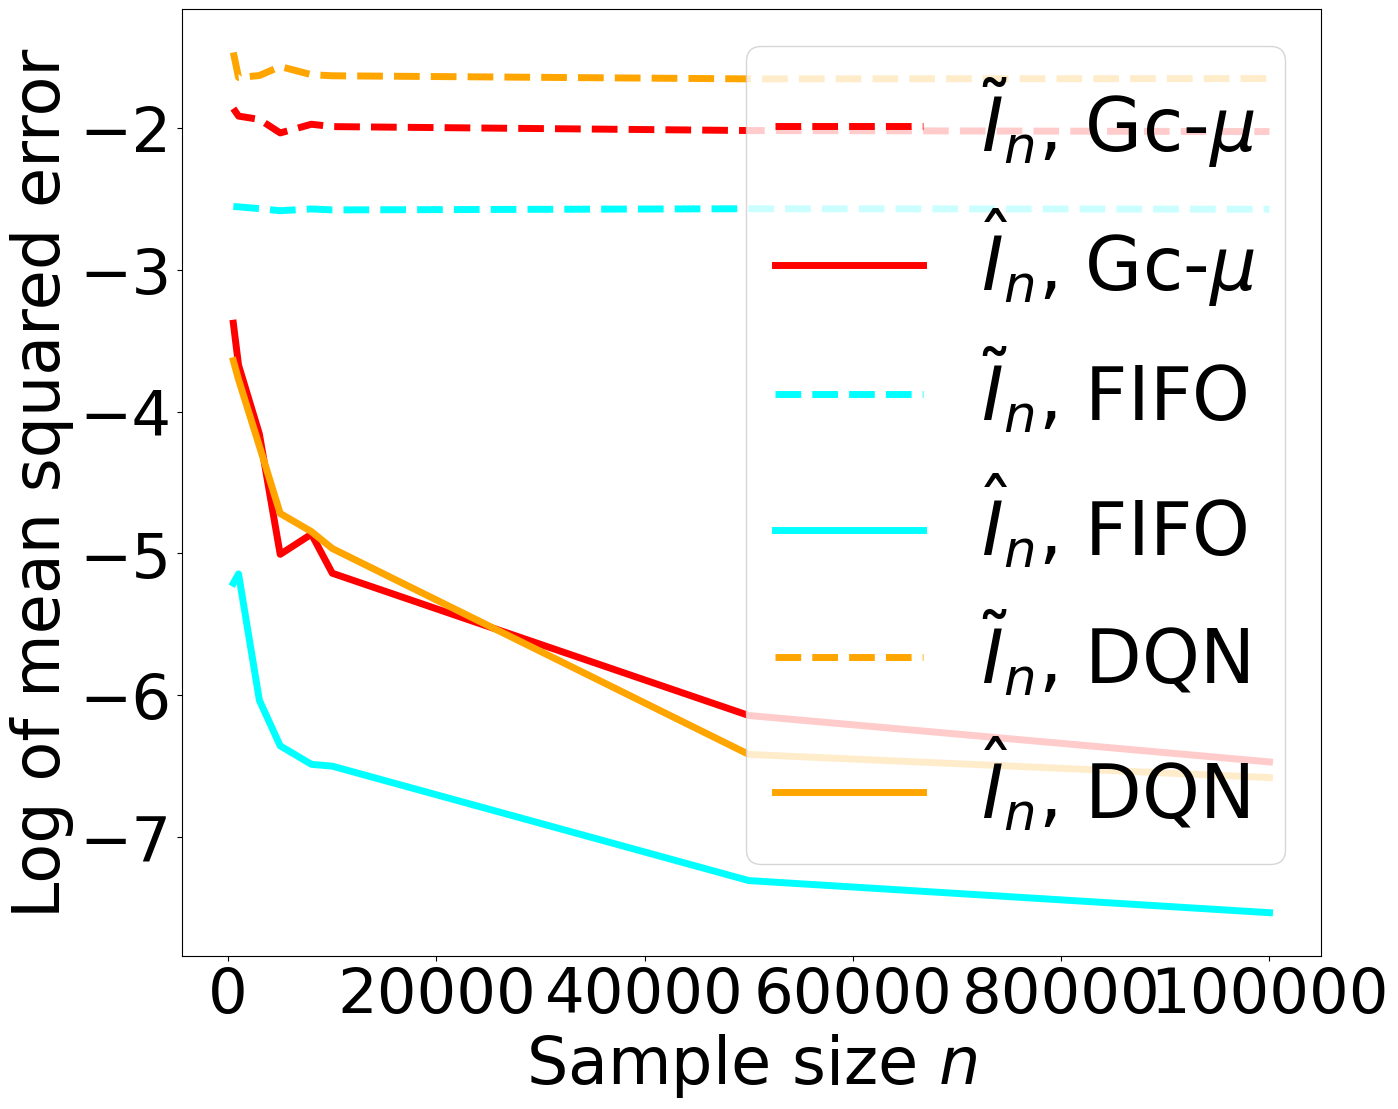

In [6]:
# data is generated from Stability_queue_kde.py and Stability_queue_convergence.py
# for d in ['c_mu_result','FIFO_result','DRL_result']:
#     print (np.mean(data_0[d]))


from random import sample
from collections import defaultdict
 

thres =  3720.66
n_samples_list = [500,1000,3000,5000,8000,10000,50000,100000]
 

policy_list = ['c_mu_result','FIFO_result','DRL_result']
label_list = {'c_mu_result':'Gc-$\mu$','DRL_result':'DQN','FIFO_result':'FIFO'}
color_list = {'c_mu_result':'r','DRL_result':'orange','FIFO_result':'cyan'}


mse_list_kde  = joblib.load('/user/ym2865/Result/model_data/simulation_stability_queueing_KDE.pkl')
mse_list_dual = joblib.load('/user/ym2865/Result/model_data/simulation_stability_queueing.pkl')
    
plt.figure(figsize=(12,10)) 



linestyle_list = ['bo:','ro-','go-.',':','-'] 
linestyle_list = ['o:','-','-.',':','-'] 
linestyle_list = {'c_mu_result':'-','DRL_result':'dotted','FIFO_result':'--'}
linestyle_list = ['bo:','ro-','go-.',':','-'] 
linestyle_list = ['o:','-','-.',':','-'] 
colors_list = ['b','r','g','c','m','y','k']

 
line_width = 5 

    
for i, d in enumerate(policy_list):    
    #print(d, mse_list[d], stability_measure_true[d])
    plt.plot(n_samples_list,np.log(mse_list_kde[d]),'--',
             label =  r'$\tilde{I}_n$, ' + label_list[d],linewidth = line_width, color = color_list[d]) 
    plt.plot(n_samples_list,np.log(mse_list_dual[d]),'-',
             label =  r'$\hat{I}_n$, ' +label_list[d] ,linewidth = line_width, color = color_list[d]) 

    
    
fig_size = 47

plt.tight_layout()   
plt.xlabel('Sample size $n$', fontsize=fig_size)
plt.ylabel('Log of mean squared error', fontsize=fig_size)
plt.legend(prop={'size': fig_size+ 6},loc='upper right')
 
plt.tick_params(axis='x', labelsize=fig_size - 2)
#plt.xticks([1000,10000,20000,30000,40000],['$10^3$','$10^4$','$2*10^4$','$3*10^4$','$4*10^4$'])
plt.tick_params(axis='y', labelsize=fig_size - 2)

plt.savefig('/user/ym2865/Result/model_data/stability_queueing_convergence.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show()

 

# Figure 6 and Table 1, stability plot

c_mu_result 0.21194 1928.7285860700517
FIFO_result 0.03887 2345.5302975955715
DRL_result 0.15741 1861.7911369409471


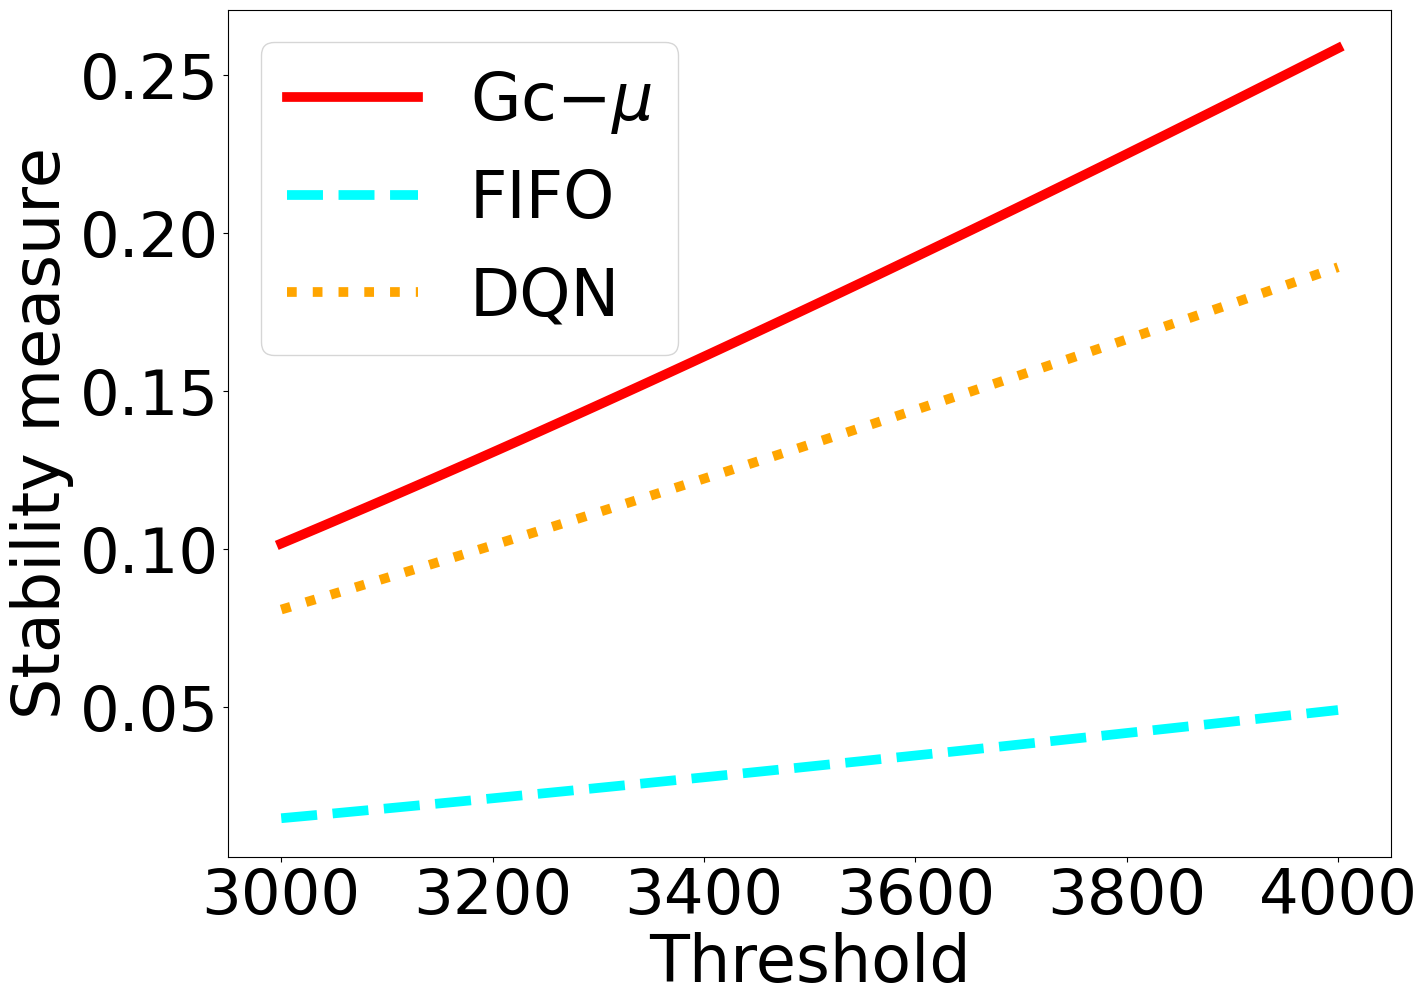

In [17]:
threshold_list = list( np.linspace(3000, 4000, 50, endpoint=True))
data_0 = joblib.load('./Result/model_data/no distribution shift_data__2023-08-13_15:09:18.pkl')

def get_last(x): #data cleaning
    return np.array([-1*_[-1] for _ in x])
for d in ['c_mu_result','FIFO_result','DRL_result']:
    data_0[d] = get_last(data_0[d])
    
len(data_0[d])

from random import sample
from collections import defaultdict

def stability_measure(x,threshold): #return the stability measure, input is the data we want to compute and the threshold

    lambda_star = optimize.bisect(robustness_estimator_grad,0, 0.001,args=(threshold,x), maxiter=100000000,xtol=0.0000001)
    exp_labmda_x = np.exp([lambda_star*_ for _ in x]) 
    stability_measure = lambda_star * threshold - np.log(np.mean(exp_labmda_x)) 
        
    return {'stability_measure':round(stability_measure,5),'mean':round(np.mean(x),2),'std':round(np.std(x),2),'lambda_star':round(lambda_star,14)}



def get_last(x):
    return np.array([-1*_[-1] for _ in x])
# def get_last(x):
#     return x

thres =  3720.66

for d in ['c_mu_result','FIFO_result','DRL_result']:
    print(d,stability_measure(data_0[d],thres)['stability_measure'], np.mean(data_0[d]))



stability_measure_result = {}
for d in ['c_mu_result','FIFO_result','DRL_result']:
    stability_measure_result[d] = []


for threshold in threshold_list:
    for d in ['c_mu_result','FIFO_result','DRL_result']:
        stability_measure_result[d].append(stability_measure(data_0[d],threshold)['stability_measure'])
    
line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

plt.plot(threshold_list, stability_measure_result['c_mu_result'],'r',label='Gc$-\mu$', linestyle='-',linewidth = line_width) 
plt.plot(threshold_list, stability_measure_result['FIFO_result'],'cyan',label='FIFO', linestyle='--',linewidth = line_width) 
plt.plot(threshold_list, stability_measure_result['DRL_result'],'orange',label='DQN', linestyle='dotted',linewidth = line_width) 
    
plt.xlabel('Threshold', fontsize=fig_size)
plt.ylabel('Stability measure', fontsize=fig_size)
plt.legend(prop={'size': fig_size}) 
plt.tick_params(axis='x', labelsize=fig_size-2)
plt.tick_params(axis='y', labelsize=fig_size-2)
plt.savefig('/user/ym2865/Result/model_data/stability_plot_queue_100K_data.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show() 

# Figure 4, plot no distribution shift data

c_mu_result_mean 1928.7285860700758 DRL_result_mean 1861.7911369409348 FIFO_result_mean 2345.5302975955783


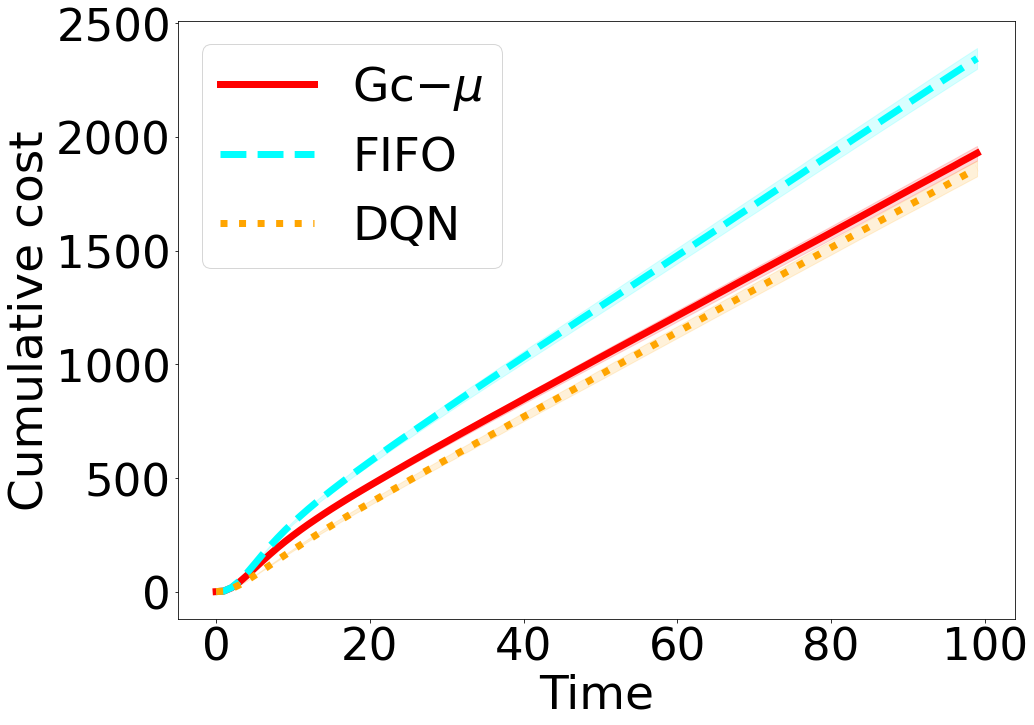

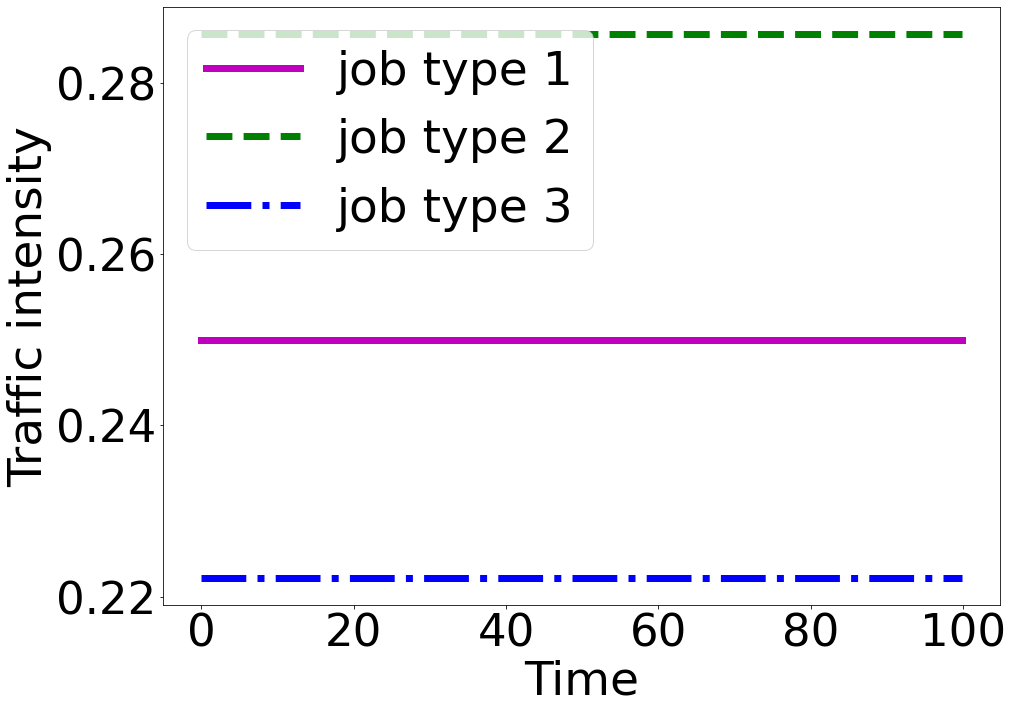

_2023-08-15_20:57:35


In [4]:
# no distribution shift
set_seed(123)
data_0 = joblib.load('./Result/model_data/no_distribution_shift_newv_10K_data__2023-08-15_20:49:09.pkl')

evaluate_policy_under_distribution(arrival_distribution, service_distribution, mixture_prob_arrival, mixture_prob_service,'no_distribution_shift_new',1,data_0)
#evaluate_policy_under_distribution(arrival_distribution, service_distribution, mixture_prob_arrival, mixture_prob_service,'no distribution shift',number_of_simulations = 10000)


# Figure 12, CVaR

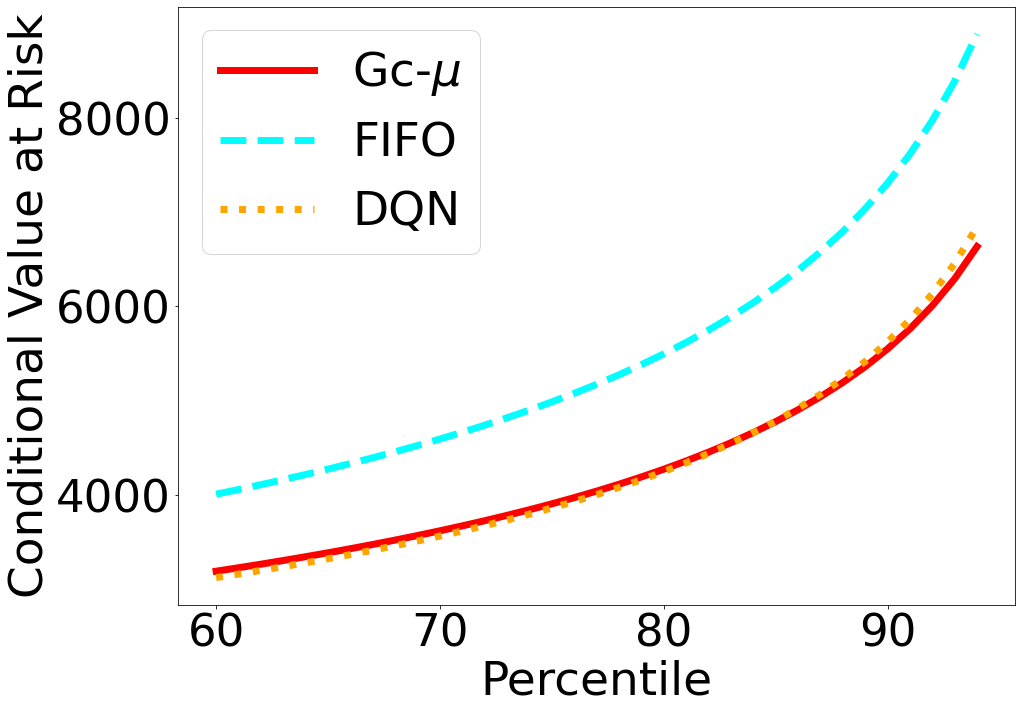

In [8]:
data_0 = joblib.load('./Result/model_data/no_distribution_shift_newv_10K_data__2023-08-15_20:49:09.pkl')

percentile_list = range(60,95)
plt.rcParams["figure.figsize"] = (15,11)
fig_size = 47
label_list = {'c_mu_result':'Gc-$\mu$','DRL_result':'DQN','FIFO_result':'FIFO'}
linestyle_list = {'c_mu_result':'-','DRL_result':'dotted','FIFO_result':'--'}
color_list = {'c_mu_result':'r','DRL_result':'orange','FIFO_result':'cyan'}


# plt.plot(xlist, c_mu_result_mean,'r',label='Gc$-\mu$', linestyle='-',linewidth = line_width) 
# plt.plot(xlist, FIFO_result_mean,'cyan',label='FIFO', linestyle='--',linewidth = line_width) 
# plt.plot(xlist, DRL_result_mean,'orange',label='DQN', linestyle='dotted',linewidth = line_width) 

#for d in ['c_mu_result','FIFO_result','DRL_result']:
for d in ['c_mu_result','FIFO_result','DRL_result']:
    result = []
    #X = [0-_[-1] for _ in data_0[d]]
    X = data_0[d]
    for i in percentile_list:
        var = np.percentile(X,i)
        cvar = [_ for _ in X if _ >= var]
        result.append(np.mean(cvar))
    
    #print(d,result)
    plt.plot(percentile_list,result,color_list[d],label = label_list[d], linestyle = linestyle_list[d],linewidth = 7) 
    
plt.xlabel('Percentile', fontsize=fig_size)
plt.ylabel(r'Conditional Value at Risk', fontsize=fig_size)
plt.legend(prop={'size': fig_size},loc='upper left') 
plt.tick_params(axis='x', labelsize=fig_size-2)
plt.tick_params(axis='y', labelsize=fig_size-2)
plt.legend(prop={'size': fig_size})
plt.savefig('./Result/model_data/Queue_CVaR.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show()

# Figure 7, Distribution shift type 1 -- Version 2

c_mu_result_mean 11909.671713888654 DRL_result_mean 14292.765008334158 FIFO_result_mean 17454.537763029515


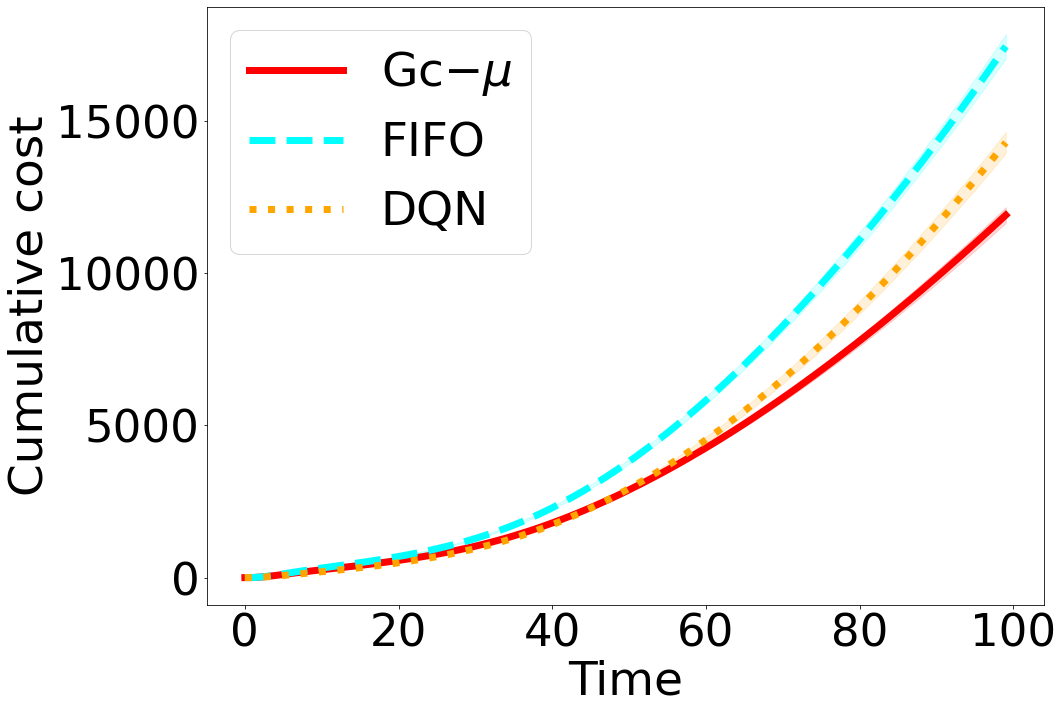

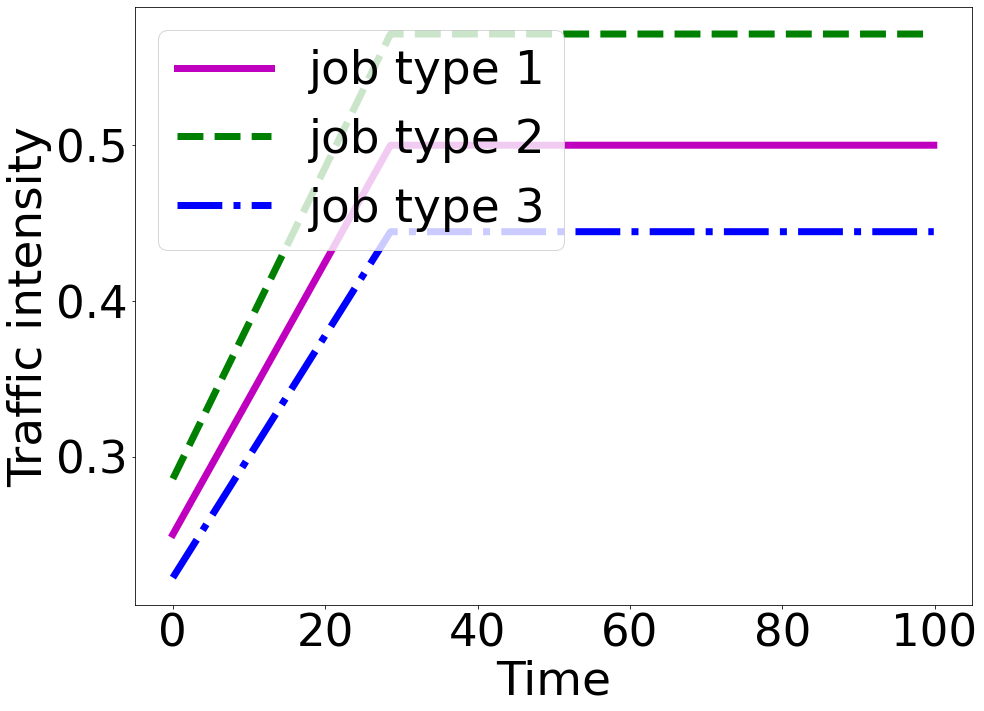

_2023-08-15_10:58:59


In [4]:
set_seed(123)
slope_distribution = 0.007

a_dist_1 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}}
]

a_dist_2  = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}}
]

a_dist_3  = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}}
]



s_dist_1 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.8)}}]

s_dist_2 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.7)}}]

s_dist_3 = [
{"type": random_exponential, "kwargs": {"rate" :customized_function_generator(func = 'constant',x0 = 0.9)}}]


arrival_distribution_t1 = [a_dist_1,a_dist_2,a_dist_3]
service_distribution_t1 = [s_dist_1,s_dist_2,s_dist_3]


 


# note that service has no mixutre
mixture_prob_arrival = [customized_function_generator(func = 'constant',x0 = 0.5),customized_function_generator(func = 'constant',x0 = 0.5)]
mixture_prob_service = [customized_function_generator(func = 'constant',x0 = 1)]



evaluate_policy_under_distribution(arrival_distribution_t1, service_distribution_t1, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_1_new',number_of_simulations = 10000)
data_0 = joblib.load('./Result/model_data/distribution_shift_type_1_10K_data__2023-08-14_12:59:34.pkl')
evaluate_policy_under_distribution(arrival_distribution_t1, service_distribution_t1, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_1_new',1,data_0)


# Figure 8, Distribution shift type 2 -- Version 2

ERROR! Session/line number was not unique in database. History logging moved to new session 371
c_mu_result_mean 15941.113585230298 DRL_result_mean 19854.412835799438 FIFO_result_mean 23828.268936368626


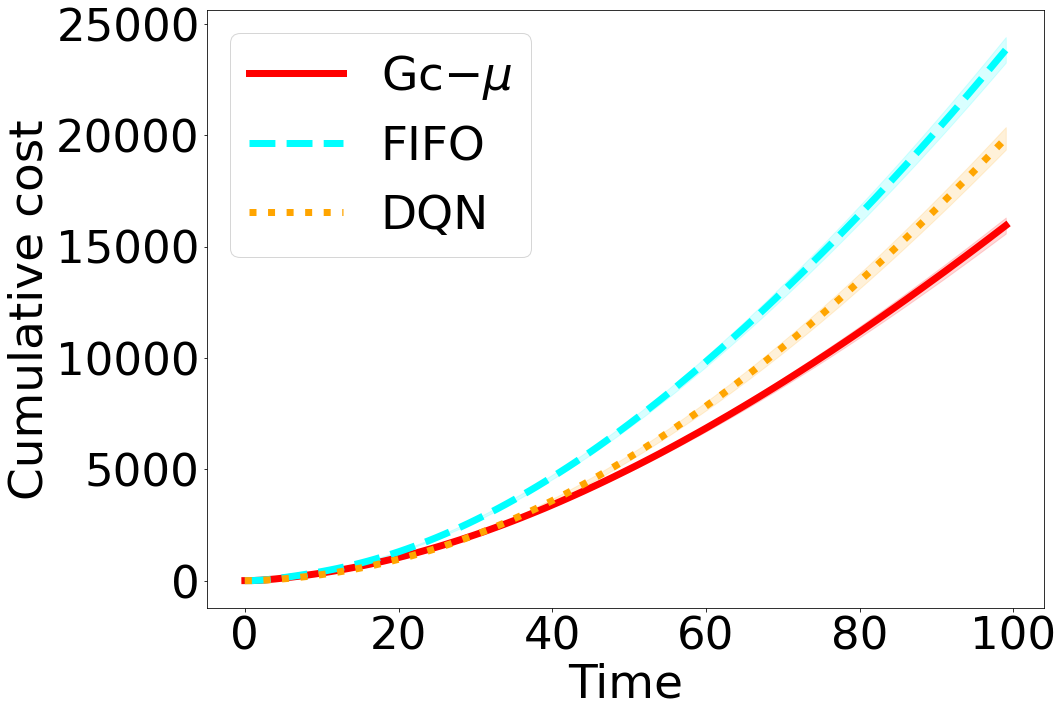

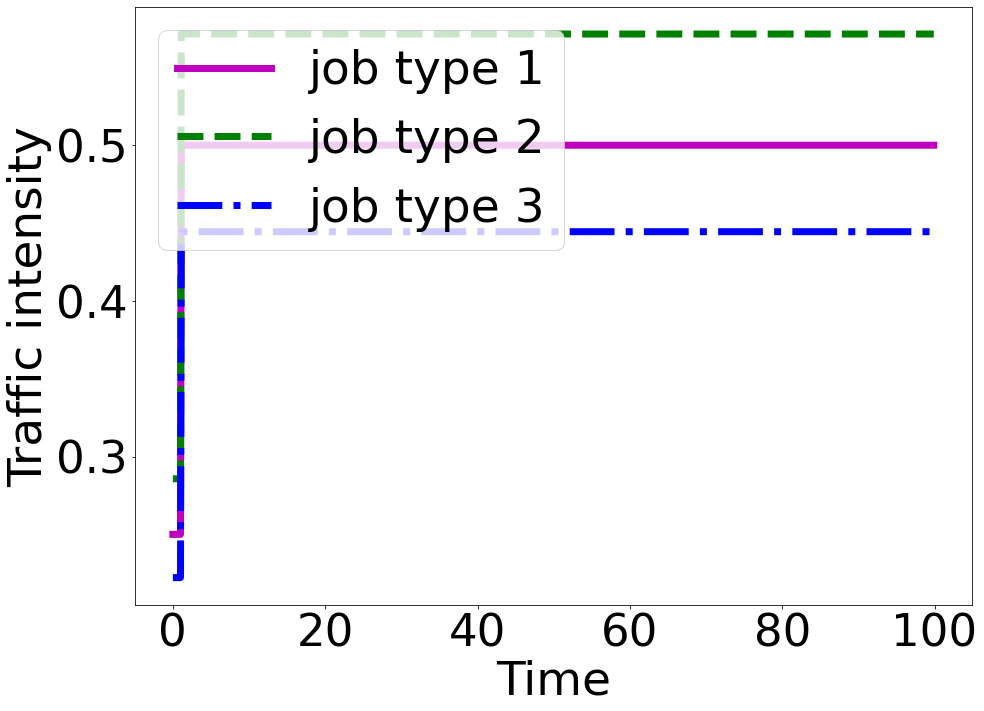

_2023-08-15_11:02:36


In [5]:
set_seed(123)
a_dist_1 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'step_func',x0 = 0.2,para = {'break_point':1,'new_value':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'step_func',x0 = 0.2,para = {'break_point':1,'new_value':0.4})}}
]

a_dist_2  =  [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'step_func',x0 = 0.2,para = {'break_point':1,'new_value':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'step_func',x0 = 0.2,para = {'break_point':1,'new_value':0.4})}}
]

a_dist_3  =  [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'step_func',x0 = 0.2,para = {'break_point':1,'new_value':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'step_func',x0 = 0.2,para = {'break_point':1,'new_value':0.4})}}
]


s_dist_1 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.8)}}]

s_dist_2 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.7)}}]

s_dist_3 = [
{"type": random_exponential, "kwargs": {"rate" :customized_function_generator(func = 'constant',x0 = 0.9)}}]


arrival_distribution_t2 = [a_dist_1,a_dist_2,a_dist_3]
service_distribution_t2 = [s_dist_1,s_dist_2,s_dist_3]


# note that service has no mixutre
mixture_prob_arrival = [customized_function_generator(func = 'constant',x0 = 0.5),customized_function_generator(func = 'constant',x0 = 0.5)]
mixture_prob_service = [customized_function_generator(func = 'constant',x0 = 1)]


evaluate_policy_under_distribution(arrival_distribution_t2, service_distribution_t2, mixture_prob_arrival, mixture_prob_service,'distribution shift type 2',number_of_simulations = 10000, if_save_last = 1)
data_0 = joblib.load('./Result/model_data/distribution_shift_type_2_10K_data__2023-08-14_17:13:45.pkl')
evaluate_policy_under_distribution(arrival_distribution_t2, service_distribution_t2, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_2_new',1,data_0)


# Figure 9, Distribution shift type 3 -- Version 2

c_mu_result_mean 6033.921746966077 DRL_result_mean 6461.662899778848 FIFO_result_mean 7016.037741923045


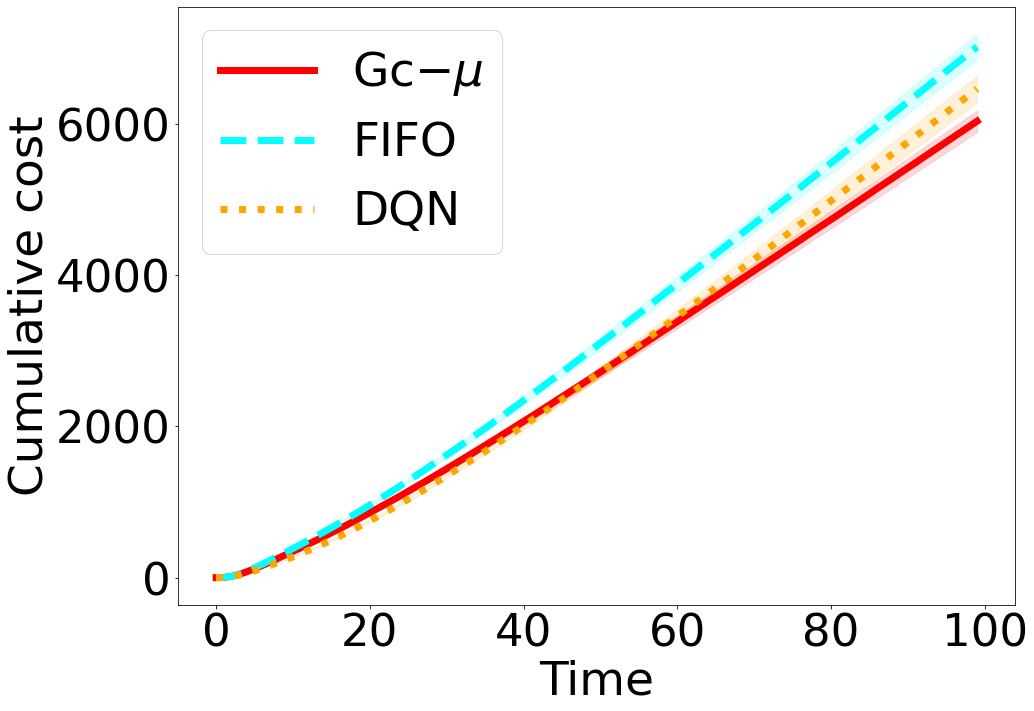

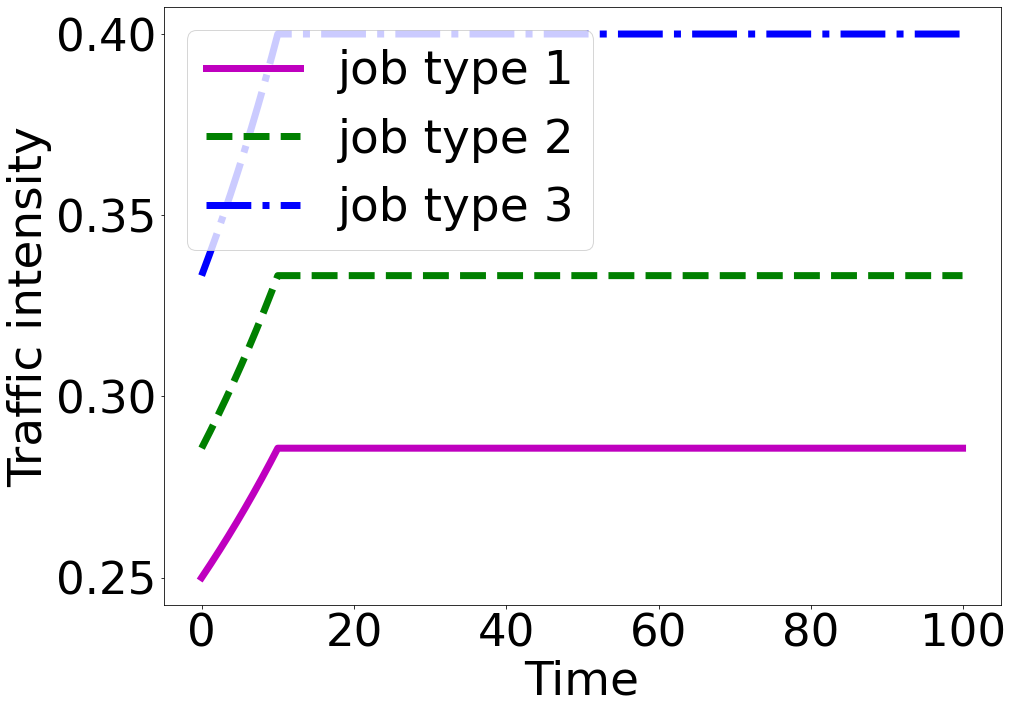

_2023-08-15_11:06:01


In [6]:
set_seed(123)
slope_distribution = 0.01


para =  0.1


a_dist_1 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.2)}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.2)}}]

a_dist_2 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.2)}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.2)}}]

a_dist_3 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.2)}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.2)}}]




s_dist_1 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear_decrease',x0 = 0.8,para = {'slope':slope_distribution,'lower_limit':0.8-para})}}]

s_dist_2 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear_decrease',x0 = 0.7,para = {'slope':slope_distribution,'lower_limit':0.7-para})}}]

s_dist_3 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear_decrease',x0 = 0.6,para = {'slope':slope_distribution,'lower_limit':0.6-para})}}]


arrival_distribution_t3 = [a_dist_1,a_dist_2,a_dist_3]
service_distribution_t3 = [s_dist_1,s_dist_2,s_dist_3]


# note that service has no mixutre
mixture_prob_arrival = [customized_function_generator(func = 'constant',x0 = 0.5),customized_function_generator(func = 'constant',x0 = 0.5)]
mixture_prob_service = [customized_function_generator(func = 'constant',x0 = 1)]


evaluate_policy_under_distribution(arrival_distribution_t3, service_distribution_t3, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_3_new', number_of_simulations = 10000, if_save_last = 0)
data_0 = joblib.load('./Result/model_data/distribution_shift_type_3_newv_10K_data__2023-08-15_01:10:48.pkl')
evaluate_policy_under_distribution(arrival_distribution_t3, service_distribution_t3, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_3_new',1,data_0)


# Figure 10, Distribution shift type 4 -- Version 2

c_mu_result_mean 48199.40998279736 DRL_result_mean 55224.98549333318 FIFO_result_mean 74607.01806098121


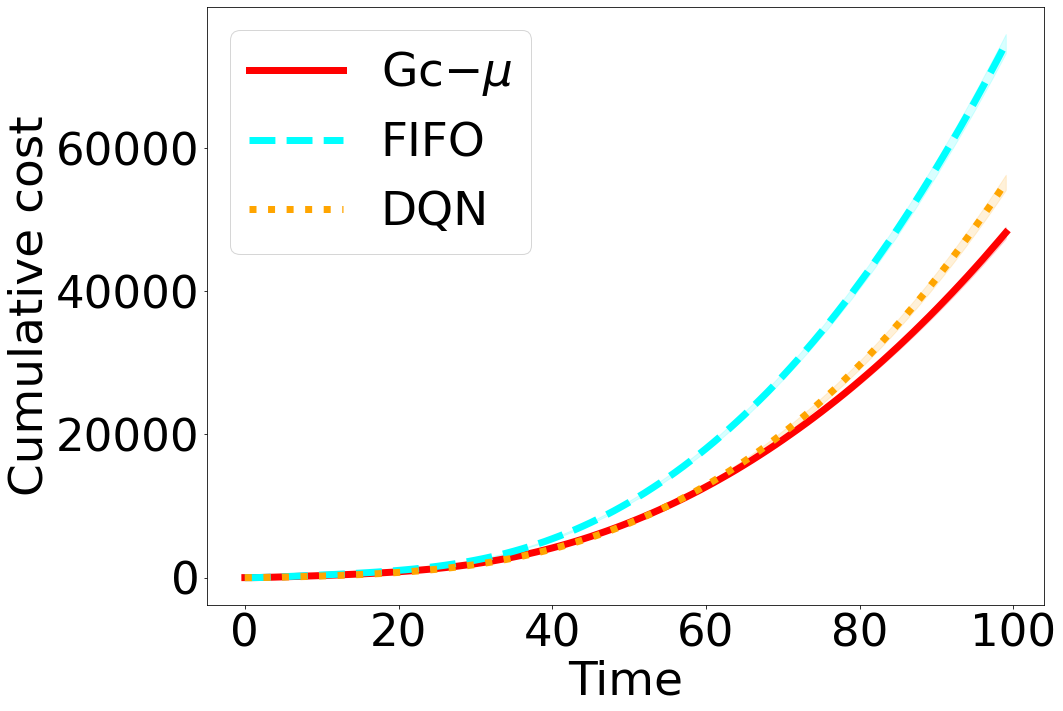

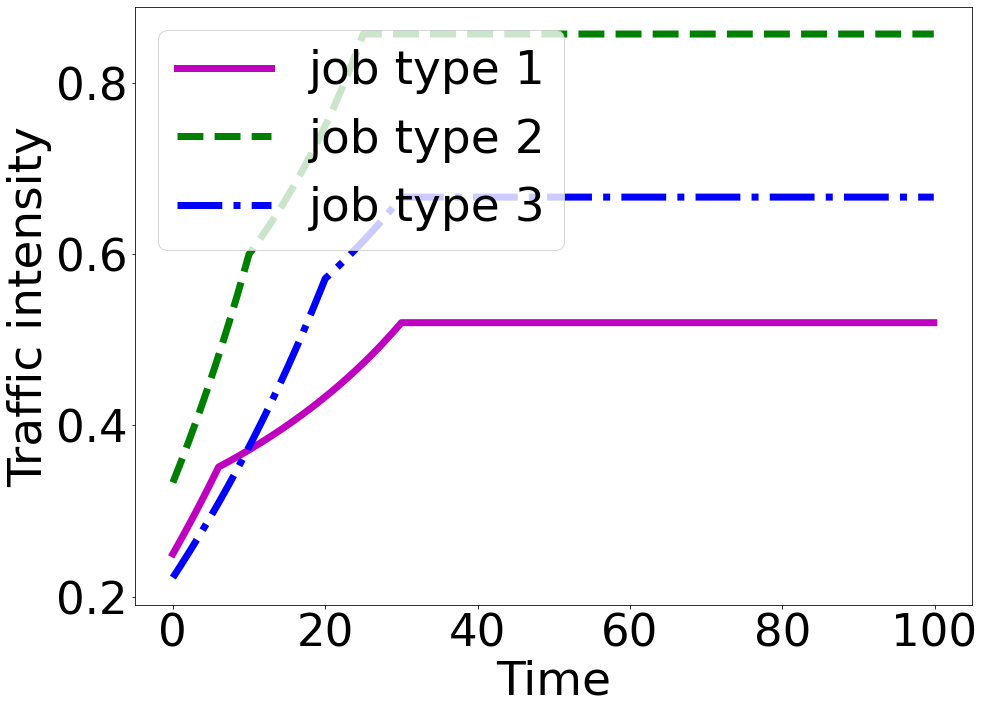

_2023-08-15_20:52:21


In [3]:
# for i in [4,6,7,8,9,10]:
#     print('i',i)
#     slope_distribution = 0.003/i

set_seed(123)
slope_distribution = 0.01

para = 0.3
a_dist_1 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.26})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.26})}}
]

a_dist_2  = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.3})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.3})}}
]

a_dist_3  = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear',x0 = 0.2,para = {'slope':slope_distribution,'upper_limit':0.4})}}
]


s_dist_1 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear_decrease',x0 = 0.8,para = {'slope':slope_distribution,'lower_limit':0.8-para})}}]

s_dist_2 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear_decrease',x0 = 0.6,para = {'slope':slope_distribution,'lower_limit':0.65-para})}}]

s_dist_3 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'truncated_linear_decrease',x0 = 0.9,para = {'slope':slope_distribution,'lower_limit':0.9-para})}}]



arrival_distribution_t4 = [a_dist_1,a_dist_2,a_dist_3]
service_distribution_t4 = [s_dist_1,s_dist_2,s_dist_3]


# note that service has no mixutre
mixture_prob_arrival = [customized_function_generator(func = 'constant',x0 = 0.5),customized_function_generator(func = 'constant',x0 = 0.5)]
mixture_prob_service = [customized_function_generator(func = 'constant',x0 = 1)]

 


evaluate_policy_under_distribution(arrival_distribution_t4, service_distribution_t4, mixture_prob_arrival, mixture_prob_service,'distribution shift type 4', number_of_simulations = 10000, if_save_last = 0)
data_0 = joblib.load('./Result/model_data/distribution_shift_type_4_nwev_10K_data__2023-08-15_19:54:21.pkl')
evaluate_policy_under_distribution(arrival_distribution_t4, service_distribution_t4, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_4_new',1,data_0)


# Figure 11, Distribution shift type 5 -- Version 2

c_mu_result_mean 5108.148607061676 DRL_result_mean 5381.7800246055185 FIFO_result_mean 6804.951660104353


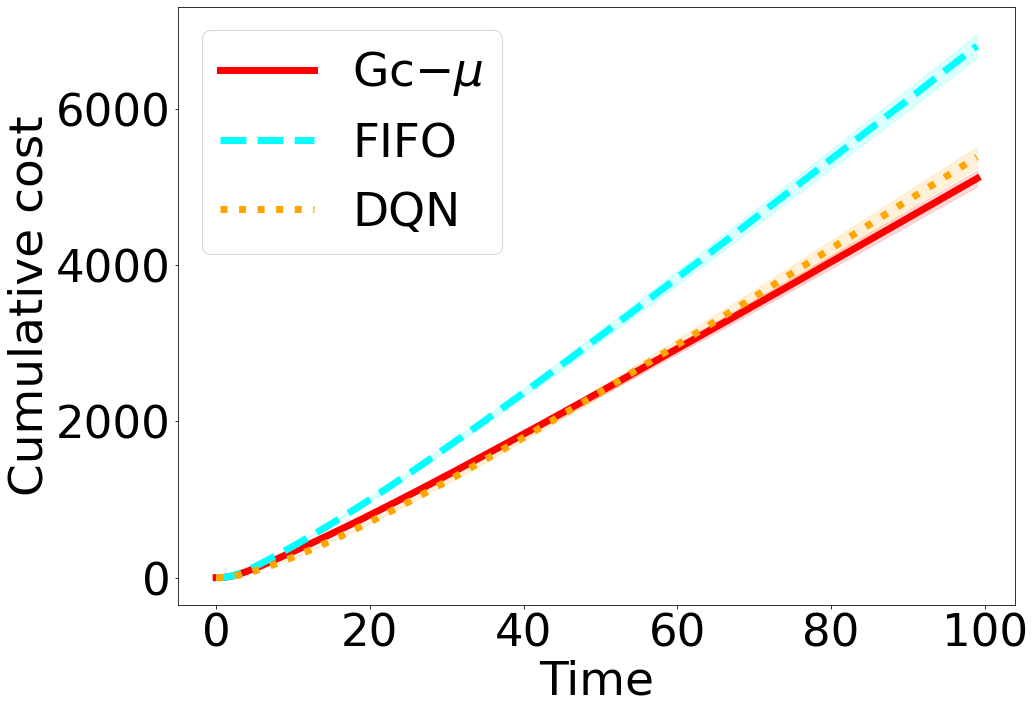

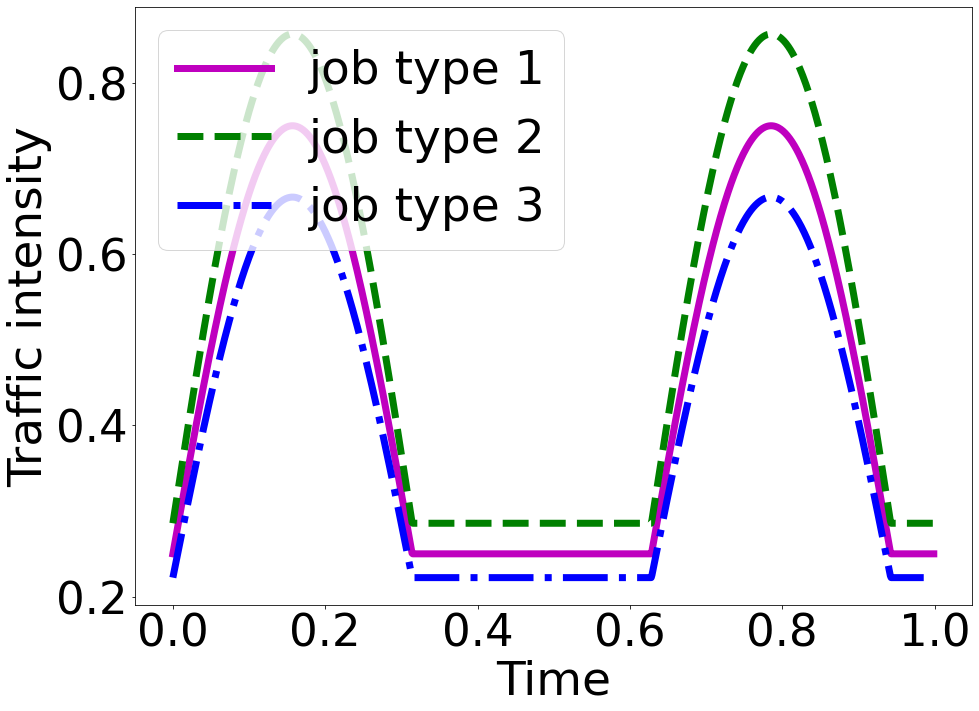

_2023-08-15_11:11:35


In [8]:
set_seed(123)
a_dist_1 = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'sin',x0 = 0.2,para = {'freq':10,'range':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'sin',x0 = 0.2,para = {'freq':10,'range':0.4})}}
]



a_dist_2  = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'sin',x0 = 0.2,para = {'freq':10,'range':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'sin',x0 = 0.2,para = {'freq':10,'range':0.4})}}
]


a_dist_3  = [
{"type": random_half_normal, "kwargs": {"rate": customized_function_generator(func = 'sin',x0 = 0.2,para = {'freq':10,'range':0.4})}},
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'sin',x0 = 0.2,para = {'freq':10,'range':0.4})}}
]



s_dist_1 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.8)}}]

s_dist_2 = [
{"type": random_exponential, "kwargs": {"rate": customized_function_generator(func = 'constant',x0 = 0.7)}}]

s_dist_3 = [
{"type": random_exponential, "kwargs": {"rate" :customized_function_generator(func = 'constant',x0 = 0.9)}}]


arrival_distribution_t5 = [a_dist_1,a_dist_2,a_dist_3]
service_distribution_t5 = [s_dist_1,s_dist_2,s_dist_3]


# note that service has no mixutre
mixture_prob_arrival = [customized_function_generator(func = 'constant',x0 = 0.5),customized_function_generator(func = 'constant',x0 = 0.5)]
mixture_prob_service = [customized_function_generator(func = 'constant',x0 = 1)]

evaluate_policy_under_distribution(arrival_distribution_t5, service_distribution_t5, mixture_prob_arrival, mixture_prob_service,'distribution shift type 5_v2',if_sin = 1)
data_0 = joblib.load('./Result/model_data/distribution_shift_type_5_10K_data__2023-08-15_05:19:51.pkl')
evaluate_policy_under_distribution(arrival_distribution_t5, service_distribution_t5, mixture_prob_arrival, mixture_prob_service,'distribution_shift_type_5_new',1,data_0,1)


# Compute true value of stability

In [ ]:
all_sim_result={}
path = '/user/ym2865/Result/queue_batch_data_06202022/'
file_list = [f for f in listdir(path) if isfile(join(path, f))][:100]

file_list = joblib.load('/user/ym2865/Result/file_list_0624.pkl')
threshold = 3720.66

def stability_measure_no_loc(data,threshold, if_plot = 0): #return the stability measure, input is the data we want to compute and the threshold
    x = data   
    lambda_star = optimize.bisect(robustness_estimator_grad,0, 100000,args=(threshold,x), maxiter=100000000,xtol=0.0000001)
    exp_labmda_x = np.exp([lambda_star*_ for _ in x]) 
    stability_measure = lambda_star * threshold - np.log(np.mean(exp_labmda_x)) 
    return {'stability_measure':round(stability_measure,5),'mean':round(np.mean(x),2),'std':round(np.std(x),2),'lambda_star':round(lambda_star,14),'threshold':threshold}


for d in ['c_mu_result','FIFO_result','DRL_result']:
    all_sim_result[d] = []
    
for file_temp in file_list:  
    data_0 = joblib.load(path + file_temp)
    threshold = 3720.66
     
    for d in ['c_mu_result','FIFO_result','DRL_result']:
        all_sim_result[d].extend(data_0[d]) #append data
        
for d in ['c_mu_result','FIFO_result','DRL_result']:        
    stability_result = stability_measure_no_loc(all_sim_result[d],threshold)
    print(d, ', stability true value = ' + str(stability_result))
    
#print(file_list)

joblib.dump(file_list,'./user/ym2865/Result/file_list_0624.pkl')

#output
'''
c_mu_result , stability true value = {'stability_measure': 0.15629, 'mean': 1931.38, 'std': 1635.39, 'lambda_star': 0.0001079570211, 'threshold': 3720.66}
FIFO_result , stability true value = {'stability_measure': 0.06354, 'mean': 2345.22, 'std': 2259.08, 'lambda_star': 5.939000403e-05, 'threshold': 3720.66}
DRL_result , stability true value = {'stability_measure': 0.12632, 'mean': 1854.04, 'std': 1740.98, 'lambda_star': 8.285496733e-05, 'threshold': 3720.66}
'''